In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
from scipy import stats
import numpy as np

# Выгрузим данные из базы в датафрейм:

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220720',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

query = '''
SELECT
    exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE
toDate(time) BETWEEN '2022-06-13' AND '2022-06-19'
AND 
exp_group BETWEEN 1 and 2
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)

In [2]:
# Посчитаем количество пользователей в обеих группах:

df.groupby('exp_group')['user_id'].count()

exp_group
1    10079
2     9952
Name: user_id, dtype: int64

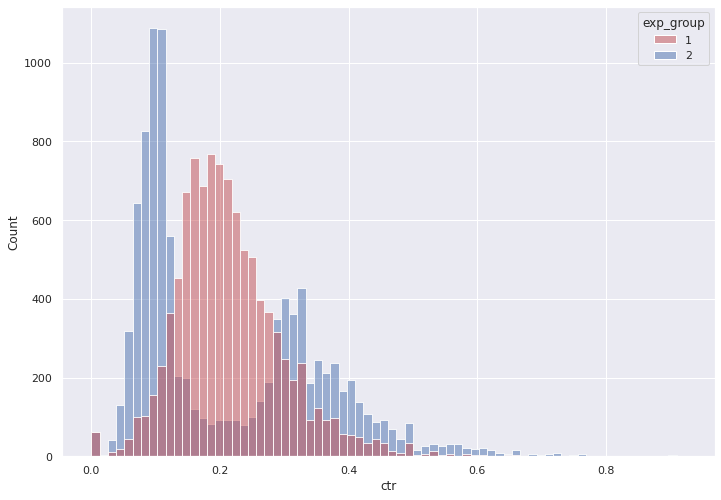

In [3]:
# Построим гистограмму, где по x - CTR, по y - частота, с которой встречаются значения CTR:

sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

_Визуально выборки выглядят разными._

In [4]:
# Проверим, одинаковые ли средние значения выборок, по t-критерию:

print(stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False))

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)


_Такой p-value не даёт нам опровергнуть нулевую гипотезу о равенстве средних.
Однако если посмотреть на распределение группы 2, мы видим, что есть значения > 1000.
Отсюда высока вероятность больших по модулю отклонений, поэтому доверять t-тесту мы не вполне можем._

In [5]:
# Проверим выборки по критерию Манна-Уитни:

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

В 56.44 % случаев A > B. Должно получиться около 50%


_Можем предположить, что в группе 1 показатель CTR в целом больше, чем в группе 2.
Проверим, так ли это, с помощью других методов анализа._

In [6]:
# Посмотрим на сглаженный CTR:

def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

<AxesSubplot:xlabel='smoothed_ctr', ylabel='Count'>

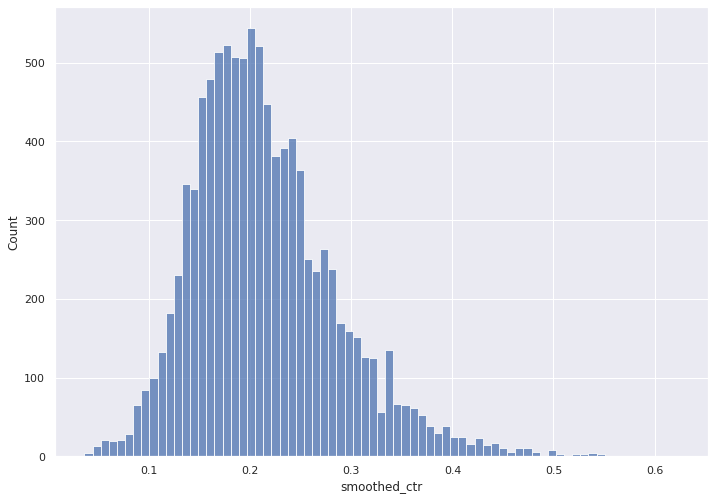

In [7]:
# Сглаженный CTR группы 1:

group1 = df[df.exp_group == 1].copy()
group1['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.histplot(group1.smoothed_ctr, 
             kde = False)

<AxesSubplot:xlabel='smoothed_ctr', ylabel='Count'>

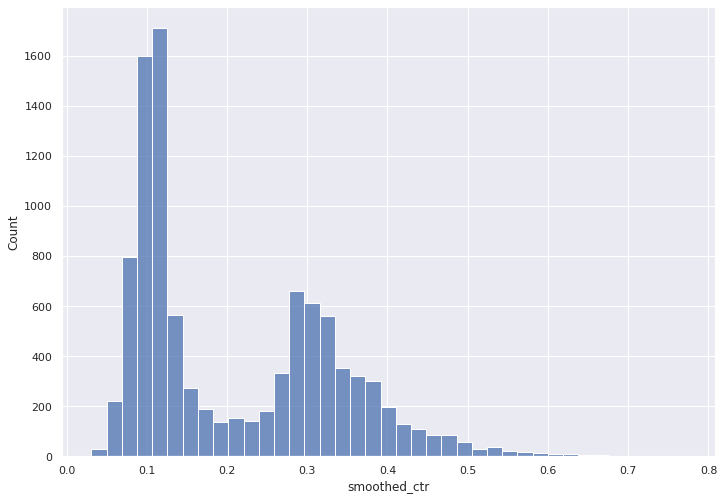

In [8]:
# Сглаженный CTR группы 2:

group2 = df[df.exp_group == 2].copy()
group2['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.histplot(group2.smoothed_ctr, 
             kde = False)

In [9]:
# Проверим, одинаковые ли сглаженные CTR двух групп, по t-критерию:

print(stats.ttest_ind(group1.smoothed_ctr,
                group2.smoothed_ctr,
                equal_var=False))

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)


_Такое значение p-value позволяет нам отвергнуть гипотезу о равенстве средних между группами._

In [10]:
# Проверим сглаженные CTR двух групп по критерию Манна-Уитни:

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= group1.smoothed_ctr.sample().values[0] > group2.smoothed_ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

В 56.49 % случаев A > B. Должно получиться около 50%


_Как и в случае с обычным CTR, мы получили, что групповой CTR в группе 1 в целом больше, чем в группе 2._

<AxesSubplot:ylabel='Count'>

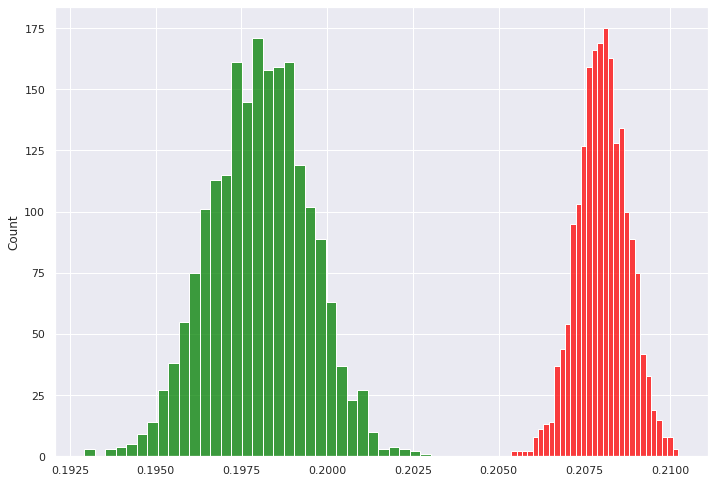

In [11]:
# Посмотрим на Пуассоновский бутстреп для подсчета разницы между глобальными CTR:

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1,
            color='red')
sns.histplot(ctr2,
            color='green')

_Здесь мы также видим, что CTR в группе 1 больше, чем в группе 2._

<AxesSubplot:ylabel='Count'>

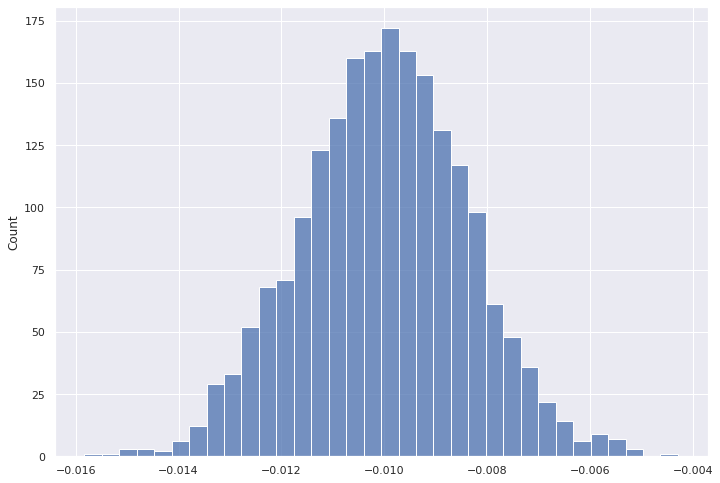

In [12]:
sns.histplot(ctr2 - ctr1)

_Поэтому разница CTR между группами 2 и 1 получалась отрицательной._

In [13]:
# Посмотрим на бакетный CTR:

q1 = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-06-13' AND '2022-06-19'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df1 = ph.read_clickhouse(q1, connection=connection)

In [14]:
# Проверим по t-критерию:

stats.ttest_ind(df1[df1.exp_group == 1].bucket_ctr, 
                   df1[df1.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

_Такое значение p-value позволяет нам отвергнуть гипотезу о равенстве средних._

In [15]:
# Проверим по критерию Манна-Уитни:

stats.mannwhitneyu(df1[df1.exp_group == 1].bucket_ctr, 
                   df1[df1.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

_Такое значение p-value также позволяет нам утверждать, что группы отличаются._

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

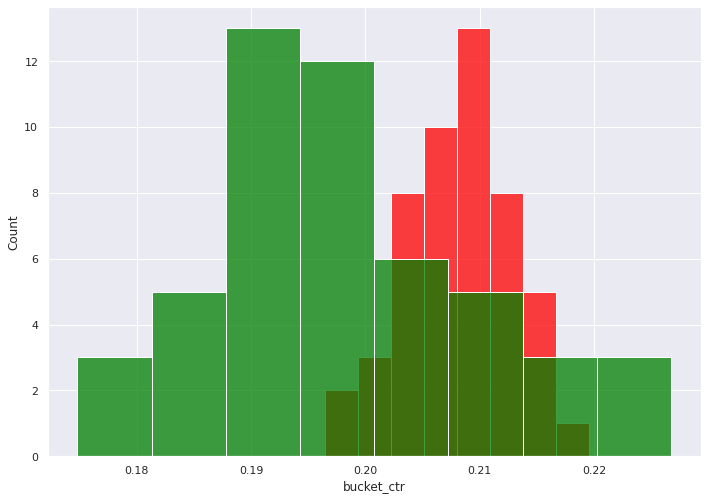

In [17]:
sns.histplot(df1[df1.exp_group == 1].bucket_ctr,
            color='red')
sns.histplot(df1[df1.exp_group == 2].bucket_ctr,
            color='green')

## Вывод

Проведённые тесты позволяют нам утверждать, что:
- различия CTR в группе 1 и в группе 2 статистически значимы;
- в группе 1 CTR выше, чем в группе 2.

То есть значения CTR в группе, где внедрили новый алгоритм, ниже, чем в контрольной группе, где оставили прежний алгоритм.

Возможно, это произошло из-за технических ошибок, недоработок в алгоритме, либо алгоритм ранее показал хорошие результаты на небольшой выборке участников в фокус-группе, но слабо показал себя в нашем эксперименте с группами ~10к человек.

Судя по результатам наших тестов, не стоит раскатывать новый алгоритм на всех пользователей, иначе есть риск значительно снизить CTR во всём сервисе.